In [1]:
#%matplotlib inline
from __future__ import print_function
import pylab

import numpy as np

import matplotlib.pyplot as plt
import time
import os
import pickle
import random

import pandas as pd

import random

#from category_encoders import *

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

plt.style.use('seaborn-white')

pylab.ion()

In [2]:
import scipy.integrate as integrate
from numpy import sqrt, sin, cos, pi, tan, sinh, cosh, exp, tanh, log, log10
import scipy.special as ssf
import math

In [3]:
def psiHOpoint(n, x):
    return exp(-0.5*x*x)*ssf.hermite(n)(x)/sqrt(math.factorial(n)*sqrt(pi)*2**n)

def psiHO(n, x):
    x=np.array(x)
    return exp(-0.5*x*x)*ssf.hermite(n)(x)/sqrt(math.factorial(n)*sqrt(pi)*2**n)

def psiHOall(n, x):
    return np.array([psiHO(i, x) for i in range(n+1)])

def HM(n, x):
    return np.array([psiHO(i, x) for i in range(n+1)]).T

def FM(k, L, x): #k Fourier modes in the interval (-L,L)
    x=np.array(x)
    xkmat = np.reshape(x, [len(x),1])*np.array(range(1,k+1))
    zeromode = 1/sqrt(2*L)*np.ones([len(x),1])
    cosmodes = cos(xkmat*pi/L)/sqrt(L)
    sinmodes = sin(xkmat*pi/L)/sqrt(L)
    return np.concatenate((zeromode,cosmodes,sinmodes),axis=1)

def FCpsiHO(n, k, L) :#k Fourier coefficients for the nth harmonic oscillator wavefunction in (-L,L)
    coeff0 = np.array([integrate.quad(lambda x: psiHOpoint(n, x)/sqrt(2*L), -L, L)[0]])
    coeffcos = np.array([integrate.quad(lambda x: psiHOpoint(n, x)*cos(x*i*pi/L)/sqrt(L), -L, L)[0] \
                         for i in range(1,k+1)])
    coeffsin = np.array([integrate.quad(lambda x: psiHOpoint(n, x)*sin(x*i*pi/L)/sqrt(L), -L, L)[0] \
                         for i in range(1,k+1)])
    return np.concatenate((coeff0,coeffcos,coeffsin))

In [4]:
def FM0(k, L, x): #k Fourier modes in the interval (-L,L)
    kvec = np.array(range(1,k+1))
    zeromode = 1/sqrt(2*L)
    cosmodes = cos(kvec*x*pi/L)/sqrt(L)
    sinmodes = sin(kvec*x*pi/L)/sqrt(L)
    return np.concatenate(([zeromode],cosmodes,sinmodes))

def D2FM0(k, L, x): #second derivative of k Fourier modes in the interval (-L,L)
    kvec = np.array(range(1,k+1))
    zeromode = 0
    cosmodes = -(kvec*pi/L)**2*cos(kvec*x*pi/L)/sqrt(L)
    sinmodes = -(kvec*pi/L)**2*sin(kvec*x*pi/L)/sqrt(L)
    return np.concatenate(([zeromode],cosmodes,sinmodes))

def H_HO_FM_int(k, L):
    return np.array([[integrate.quad(lambda x: FM0(k, L, x)[i]*(x**2*FM0(k, L, x)[j]- D2FM0(k, L, x)[j]), -L, L)[0] \
                     for i in range(2*k+1)] for j in range(2*k+1)])

def V_AHO(x):
    return -x**2/2-x+x**4/16

def H_AHO_FM_int(k, L, V): #V is the function that calculates the potential
    return np.array([[integrate.quad(lambda x: FM0(k, L, x)[i]*(2*V(x)*FM0(k, L, x)[j]- D2FM0(k, L, x)[j]), -L, L)[0] \
                     for i in range(2*k+1)] for j in range(2*k+1)])

In [5]:
def make_lower(side_len):
    mask = np.zeros((side_len, side_len), dtype = np.intc)
    for i in range(side_len):
        for j in range(i+1):
            mask[i, j] = 1
    mask = torch.from_numpy(mask)
    return mask

def make_diag(side_len):
    mask = np.zeros((side_len, side_len), dtype = np.intc)
    for i in range(side_len):
        mask[i, i] = 1
    mask = torch.from_numpy(mask)
    return mask

## Variational Inference

In [6]:
#define QVI module
class QVI(nn.Module):  #QVI with any basis

    def __init__(self, Temp, n_ES, H_matrix):
        super(QVI, self).__init__()
        
        self.n_Ba = H_matrix.shape[0] #get size of basis set from Hamiltonian matrix
        self.n_EL = n_ES
        self.T = Temp
        self.H_MAT = torch.from_numpy(H_matrix)
        
        self.levels = torch.nn.Parameter(torch.from_numpy(np.random.uniform(1,2,self.n_EL+1)))
        self.levels.requires_grad = True
        
        self.var_BaC = torch.nn.Parameter(torch.from_numpy(np.random.uniform(-1,1,[self.n_Ba, self.n_EL+1])))
        self.var_BaC.requires_grad = True
        
        self.mask = (make_lower(self.n_EL+1) - make_diag(self.n_EL+1) ) > 0 #convert to boolean
        self.diag = make_diag(self.n_EL+1) > 0 #convert to boolean   

        

    def forward(self):
        
        
        norms_BaC = torch.linalg.norm(self.var_BaC, dim = 0)
        var_BaC_N = self.var_BaC/norms_BaC #normalise the coefficients of basis states before each forward propagation
        logits = F.softmin(self.levels, dim = 0)

        loss_vNE = torch.sum(torch.masked_select(torch.matmul(torch.transpose(var_BaC_N, 0, 1) ,\
                     torch.matmul(self.H_MAT, var_BaC_N)), self.diag) * logits)
        c_orth = 1000
        loss_orth = c_orth * torch.mean(torch.masked_select(torch.matmul(torch.transpose(var_BaC_N, 0, 1),var_BaC_N) \
                                                                  , self.mask)**2)

        loss_VI = self.T*torch.sum(logits * F.log_softmax(-1 * self.levels, dim = 0))
                                                             

        loss = loss_vNE + loss_VI + loss_orth
        return loss, loss_vNE, loss_VI, loss_orth, self.levels, logits #, self.var_BaC
    
    

In [7]:
def main_train_states_QVI(G, epochs = 100000, step = 1e-3):
    
    optimiser = torch.optim.Adam(G.parameters(), lr=step)
    
    loss_hist = np.zeros((epochs,), dtype = float)
    loss_vNE_hist = np.zeros((epochs,), dtype = float)
    loss_VI_hist = np.zeros((epochs,), dtype = float)
    loss_orth_hist = np.zeros((epochs,), dtype = float)

    levels_hist = []
    logits_hist = []
    
    for i in range(epochs):
        [loss, loss_vNE, loss_VI, loss_orth, levels, logits] = G()
    
    
        loss_hist[i] = loss.tolist()
        loss_vNE_hist[i] = loss_vNE.tolist()
        loss_VI_hist[i] = loss_VI.tolist()
        loss_orth_hist[i] = loss_orth.tolist()
        levels_hist.append(levels.tolist())
        logits_hist.append(logits.tolist())
    
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
        if i % 10000 == 0:
                print('Batch number ', i)
                print('Loss: ', loss_hist[i])
                print('Loss_orth: ', loss_orth_hist[i])
                print('Loss_vNE: ', loss_vNE_hist[i])
                print('Loss_vI: ', loss_VI_hist[i])
                print('@----------------------------------------------------------@')
                #writer.add_summary(summary, i)
                #writer.flush()
        
        
    var_BaC = G.var_BaC
    norms_BaC = torch.linalg.norm(var_BaC, dim = 0)
    var_BaC_N = (var_BaC / norms_BaC).detach().numpy() #normalise the coefficients of basis states
    levels_hist = np.array(levels_hist)
    logits_hist = np.array(logits_hist)

    
    ##Sort energy levels and associated coefficients of basis states in ascending order
    fin_EL = G.levels
    fin_EL = fin_EL.detach()
    fin_logits = F.softmin(fin_EL, dim = 0)
    fin_EL = fin_EL.numpy()
    fin_logits = fin_logits.numpy()
    
    fin_EL_argsort = fin_EL.argsort()
    levels_hist = levels_hist[:, fin_EL_argsort]
    logits_hist = logits_hist[:, fin_EL_argsort]
    var_BaC_N = var_BaC_N[:, fin_EL_argsort]
    fin_EL = fin_EL[fin_EL_argsort]
    fin_logits = fin_logits[fin_EL_argsort]
    #EL_ranks = np.empty_like(fin_EL_argsort)
    #EL_ranks[fin_EL_argsort] = np.arange(len(fin_EL))
    
    
    return loss_hist, loss_vNE_hist, loss_VI_hist, loss_orth_hist, levels_hist, logits_hist, var_BaC_N, fin_EL, fin_logits
    

## Fourier Basis

## High temperature (T = 2)

In [8]:
n_FM = 20
box_len = 10

H_HO_FM = H_HO_FM_int(n_FM, box_len)


In [39]:
n_EL = 10
T = 2
qvi_HO_FM = QVI(T, n_EL, H_HO_FM)
epochs = 100000
step = 1e-3

[loss_hist, loss_vNE_hist, loss_VI_hist, loss_orth_hist, levels_hist, logits_hist, var_FC_N, levels_fin, logits_fin] = \
                                                                main_train_states_QVI(qvi_HO_FM, epochs, step)

Batch number  0
Loss:  70.2647838009419
Loss_orth:  27.321240632067244
Loss_vNE:  47.63531435274364
Loss_vI:  -4.691771183868978
@----------------------------------------------------------@
Batch number  10000
Loss:  0.09907862509542509
Loss_orth:  3.371070885885763e-06
Loss_vNE:  2.128275610009845
Loss_vI:  -2.029200355985306
@----------------------------------------------------------@
Batch number  20000
Loss:  0.08271955197736092
Loss_orth:  5.149446649087958e-07
Loss_vNE:  2.1634420404920354
Loss_vI:  -2.0807230034593394
@----------------------------------------------------------@
Batch number  30000
Loss:  0.08268975990736635
Loss_orth:  6.213913519018403e-07
Loss_vNE:  2.163544764451848
Loss_vI:  -2.0808556259358335
@----------------------------------------------------------@
Batch number  40000
Loss:  0.0826866683510201
Loss_orth:  7.047455263732494e-07
Loss_vNE:  2.163563217034162
Loss_vI:  -2.0808772534286684
@----------------------------------------------------------@
Batch n

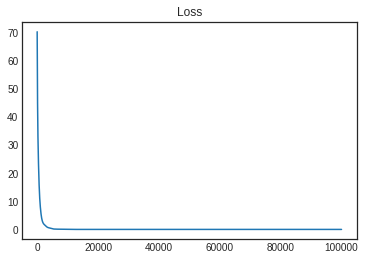

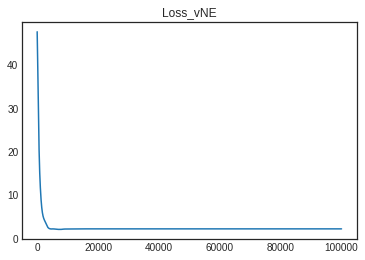

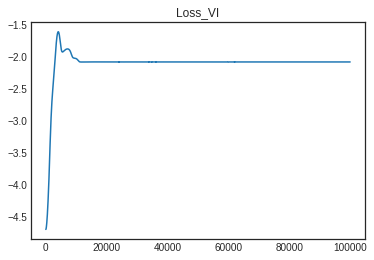

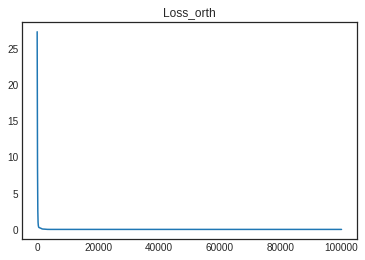

In [40]:
plt.plot(np.arange(epochs), loss_hist)
plt.title("Loss")
plt.show()
plt.plot(np.arange(epochs), loss_vNE_hist)
plt.title("Loss_vNE")
plt.show()
plt.plot(np.arange(epochs), loss_VI_hist)
plt.title("Loss_VI")
plt.show()
plt.plot(np.arange(epochs), loss_orth_hist)
plt.title("Loss_orth")
plt.show()

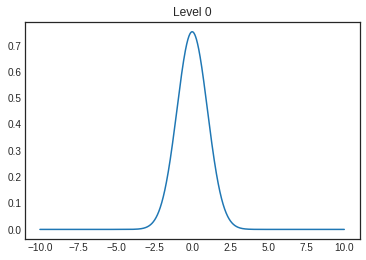

Square integrated over the region: 1.000000000000021


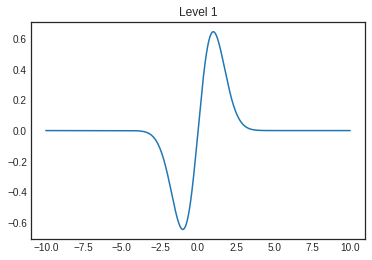

Square integrated over the region: 1.000000000000021


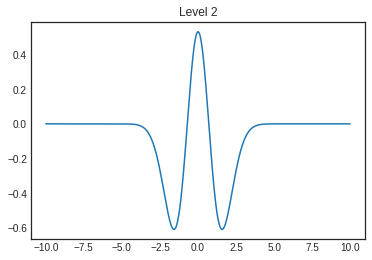

Square integrated over the region: 1.0000000000000213


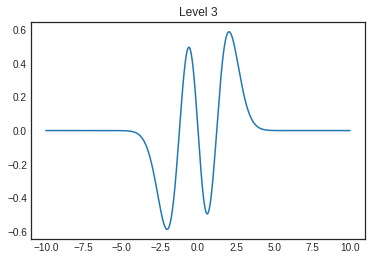

Square integrated over the region: 1.0000000000000213


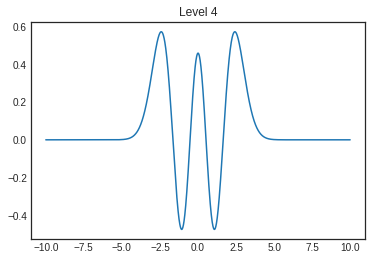

Square integrated over the region: 1.0000000000000213


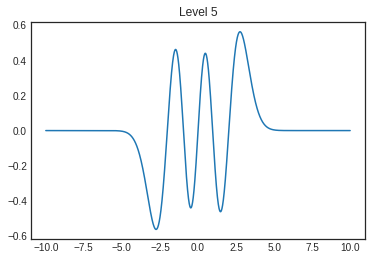

Square integrated over the region: 1.0000000000000213


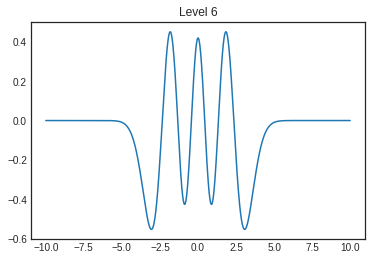

Square integrated over the region: 1.0000000000000215


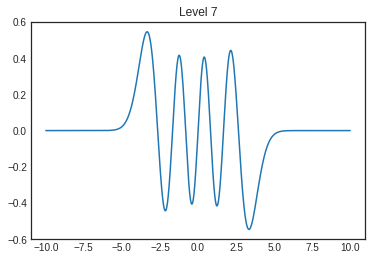

Square integrated over the region: 1.0000000000000213


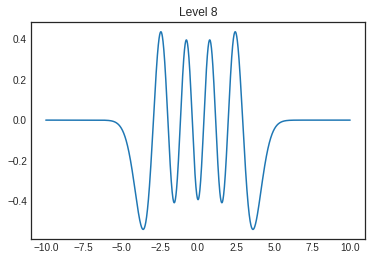

Square integrated over the region: 1.0000000000000209


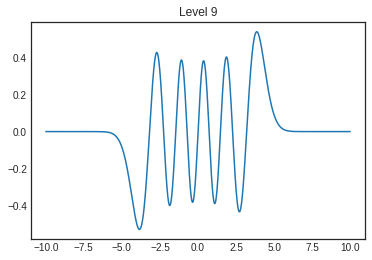

Square integrated over the region: 1.000000000000021


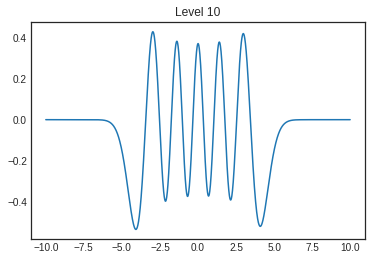

Square integrated over the region: 1.000000000000021


In [41]:
x = np.arange(-10, 10 , 0.01)
k = n_FM
L = box_len
Y = FM(k, L, x)

SUP = np.matmul(Y, var_FC_N)

for i in range(n_EL+1):
    plt.plot(x, SUP[:, i])
    plt.title("Level " + str(i))
    plt.show()
    print("Square integrated over the region: " + str(np.sum(SUP[:, i] * SUP[:, i]) * 0.01)) #check wavefunction normalisation

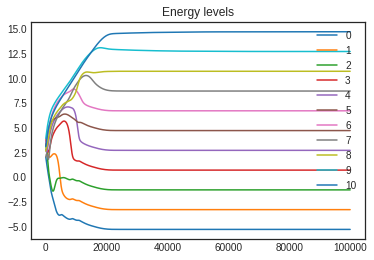

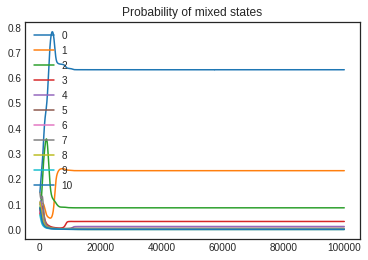

In [42]:
for i in range(n_EL+1):
    plt.plot(np.arange(epochs), levels_hist[:,i]*T, label = str(i))

plt.title("Energy levels")    
plt.legend()
plt.show()

for i in range(n_EL+1):
    plt.plot(np.arange(epochs), logits_hist[:,i], label = str(i))

plt.title("Probability of mixed states")    
plt.legend()
plt.show()

In [43]:
print("Energy: ")
print(levels_fin)
print("Probabilities: ")
print(logits_fin)

Energy: 
[-2.65000147 -1.65001632 -0.6500164   0.34998368  1.34998367  2.34998384
  3.34998419  4.34998508  5.34998738  6.35013186  7.34986529]
Probabilities: 
[6.32127665e-01 2.32550227e-01 8.55504537e-02 3.14722506e-02
 1.15779940e-02 4.25930529e-03 1.56691029e-03 5.76433573e-04
 2.12057572e-04 7.80003510e-05 2.87023756e-05]


## Higher temperature (T = 4)

In [39]:
n_FM = 20
box_len = 10

H_HO_FM = H_HO_FM_int(n_FM, box_len)


In [29]:
n_EL = 10
T = 4
qvi_HO_FM = QVI(T, n_EL, H_HO_FM)
epochs = 100000
step = 1e-3

[loss_hist, loss_vNE_hist, loss_VI_hist, loss_orth_hist, levels_hist, logits_hist, var_FC_N, levels_fin, logits_fin] = \
                                                                main_train_states_QVI(qvi_HO_FM, epochs, step)

Batch number  0
Loss:  60.364837810754935
Loss_orth:  24.785048786880534
Loss_vNE:  44.99018695792394
Loss_vI:  -9.410397934049534
@----------------------------------------------------------@
Batch number  10000
Loss:  -2.7060068134192394
Loss_orth:  1.4633659293980284e-05
Loss_vNE:  3.974244500777497
Loss_vI:  -6.6802659478560305
@----------------------------------------------------------@
Batch number  20000
Loss:  -2.7146274330839852
Loss_orth:  3.7874771538931556e-07
Loss_vNE:  3.992710335534598
Loss_vI:  -6.707338147366299
@----------------------------------------------------------@
Batch number  30000
Loss:  -2.714626880608217
Loss_orth:  8.866520946749856e-07
Loss_vNE:  3.9927028661895796
Loss_vI:  -6.707330633449891
@----------------------------------------------------------@
Batch number  40000
Loss:  -2.714626536600119
Loss_orth:  1.234743285087749e-06
Loss_vNE:  3.9927185338092603
Loss_vI:  -6.707346305152664
@----------------------------------------------------------@
Batch

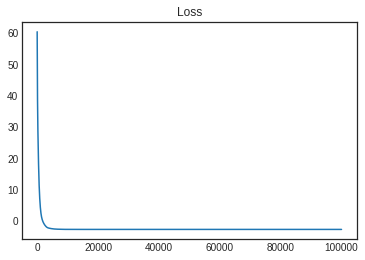

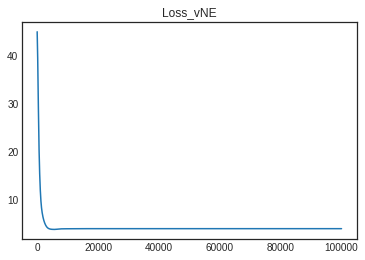

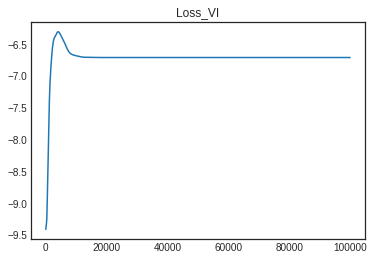

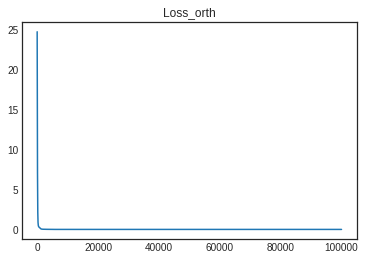

In [30]:
plt.plot(np.arange(epochs), loss_hist)
plt.title("Loss")
plt.show()
plt.plot(np.arange(epochs), loss_vNE_hist)
plt.title("Loss_vNE")
plt.show()
plt.plot(np.arange(epochs), loss_VI_hist)
plt.title("Loss_VI")
plt.show()
plt.plot(np.arange(epochs), loss_orth_hist)
plt.title("Loss_orth")
plt.show()

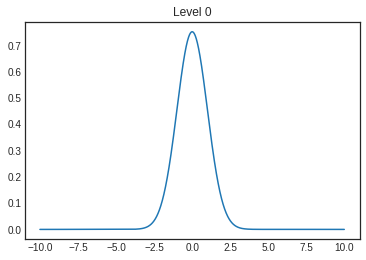

Square integrated over the region: 1.0000000000000204


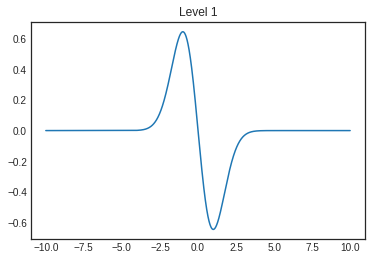

Square integrated over the region: 1.0000000000000215


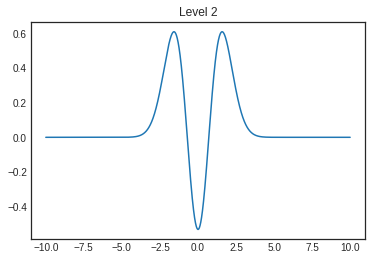

Square integrated over the region: 1.000000000000022


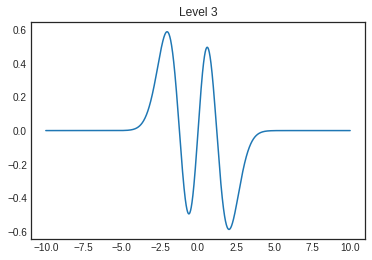

Square integrated over the region: 1.0000000000000213


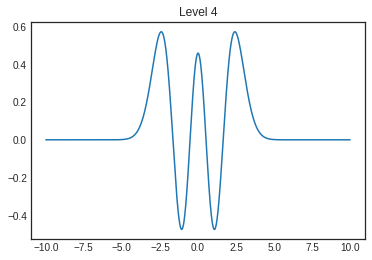

Square integrated over the region: 1.0000000000000207


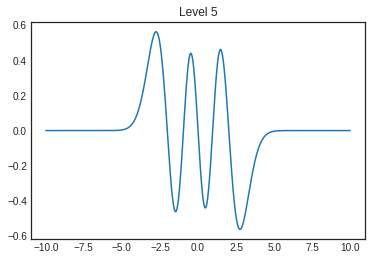

Square integrated over the region: 1.000000000000021


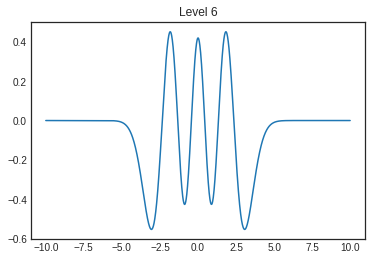

Square integrated over the region: 1.0000000000000215


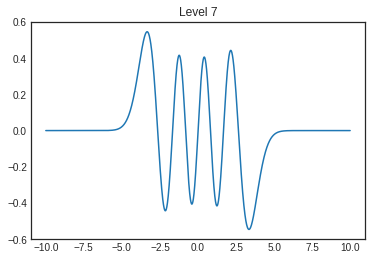

Square integrated over the region: 1.000000000000021


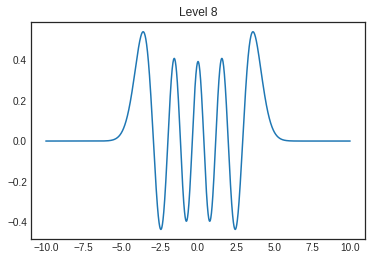

Square integrated over the region: 1.000000000000021


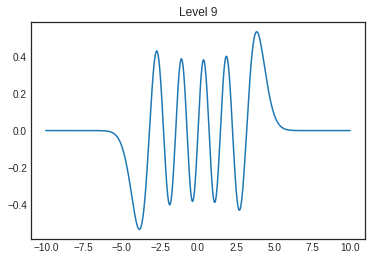

Square integrated over the region: 1.0000000000000215


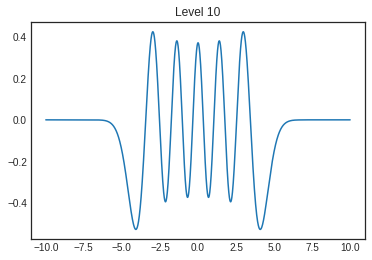

Square integrated over the region: 1.000000000000021


In [31]:
x = np.arange(-10, 10 , 0.01)
k = n_FM
L = box_len
Y = FM(k, L, x)

SUP = np.matmul(Y, var_FC_N)

for i in range(n_EL+1):
    plt.plot(x, SUP[:, i])
    plt.title("Level " + str(i))
    plt.show()
    print("Square integrated over the region: " + str(np.sum(SUP[:, i] * SUP[:, i]) * 0.01)) #check wavefunction normalisation

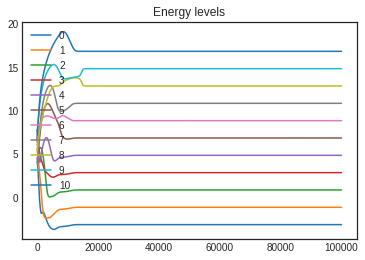

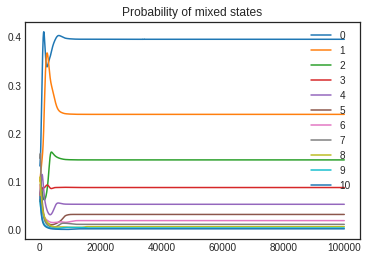

In [32]:
for i in range(n_EL+1):
    plt.plot(np.arange(epochs), levels_hist[:,i]*T, label = str(i))

plt.title("Energy levels")    
plt.legend()
plt.show()

for i in range(n_EL+1):
    plt.plot(np.arange(epochs), logits_hist[:,i], label = str(i))

plt.title("Probability of mixed states")    
plt.legend()
plt.show()

In [33]:
print("Energy: ")
print(levels_fin)
print("Probabilities: ")
print(logits_fin)

Energy: 
[-0.78470721 -0.28471342  0.21521343  0.71530128  1.21528656  1.71529072
  2.2153347   2.71528615  3.21528638  3.71524188  4.21528622]
Probabilities: 
[0.39507913 0.23962909 0.14535303 0.08815332 0.05346848 0.03243014
 0.01966901 0.01193044 0.00723617 0.00438916 0.00266204]


## Low temperature (T = 0.5)

In [29]:
n_FM = 20
box_len = 10


H_HO_FM = H_HO_FM_int(n_FM, box_len)


In [19]:
n_EL = 10
T = 0.5
qvi_HO_FM = QVI(T, n_EL, H_HO_FM)
epochs = 100000
step = 1e-3

[loss_hist, loss_vNE_hist, loss_VI_hist, loss_orth_hist, levels_hist, logits_hist, var_FC_N, levels_fin, logits_fin] = \
                                                                main_train_states_QVI(qvi_HO_FM, epochs, step)

Batch number  0
Loss:  67.82025954299716
Loss_orth:  22.38033094756641
Loss_vNE:  46.62650744560933
Loss_vI:  -1.1865788501785741
@----------------------------------------------------------@
Batch number  10000
Loss:  1.00822901705528
Loss_orth:  3.481223306745791e-07
Loss_vNE:  1.0227672964062857
Loss_vI:  -0.01453862747333657
@----------------------------------------------------------@
Batch number  20000
Loss:  0.9908699183447947
Loss_orth:  1.3296049653466752e-06
Loss_vNE:  1.0372684654964988
Loss_vI:  -0.04639987675666949
@----------------------------------------------------------@
Batch number  30000
Loss:  0.9907620514709019
Loss_orth:  1.0261769662058537e-06
Loss_vNE:  1.0372806205917902
Loss_vI:  -0.04651959529785445
@----------------------------------------------------------@
Batch number  40000
Loss:  0.9907613134549724
Loss_orth:  1.0609846902620108e-06
Loss_vNE:  1.0372798562645325
Loss_vI:  -0.046519603794250214
@----------------------------------------------------------@

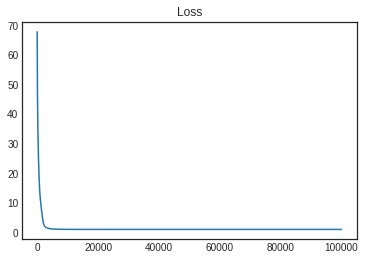

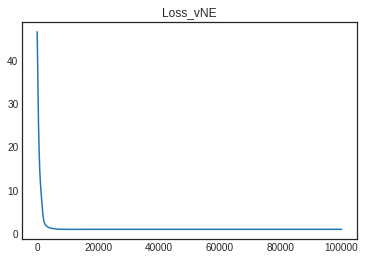

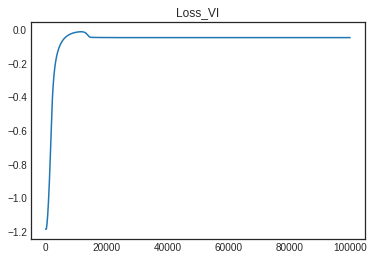

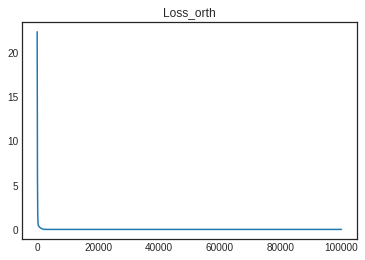

In [20]:
plt.plot(np.arange(epochs), loss_hist)
plt.title("Loss")
plt.show()
plt.plot(np.arange(epochs), loss_vNE_hist)
plt.title("Loss_vNE")
plt.show()
plt.plot(np.arange(epochs), loss_VI_hist)
plt.title("Loss_VI")
plt.show()
plt.plot(np.arange(epochs), loss_orth_hist)
plt.title("Loss_orth")
plt.show()

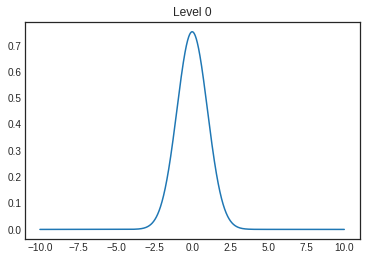

Square integrated over the region: 1.000000000000021


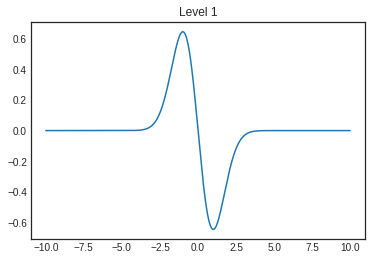

Square integrated over the region: 1.000000000000021


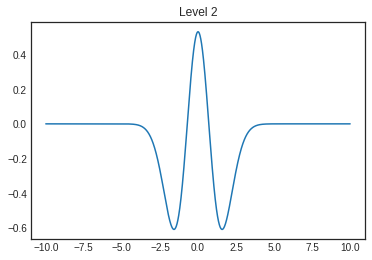

Square integrated over the region: 1.000000000000021


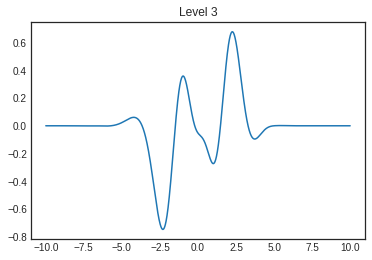

Square integrated over the region: 1.0000000000000213


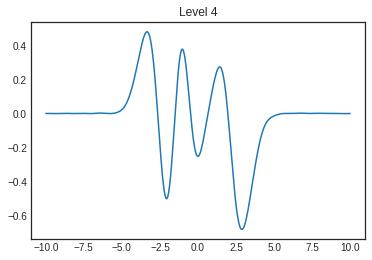

Square integrated over the region: 1.000000000000021


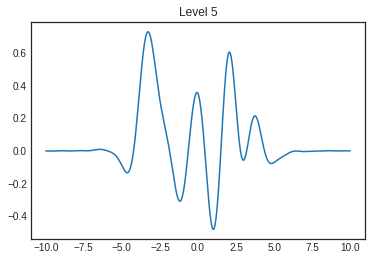

Square integrated over the region: 1.0000000000000215


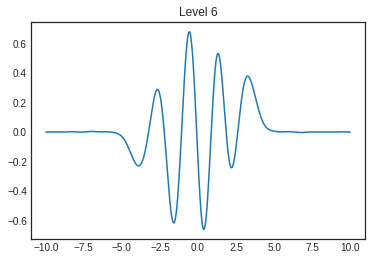

Square integrated over the region: 1.0000000000000215


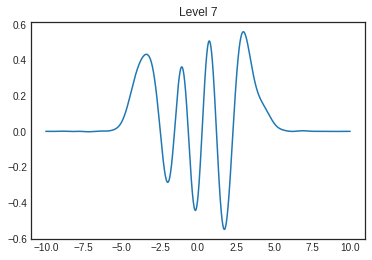

Square integrated over the region: 1.0000000000000213


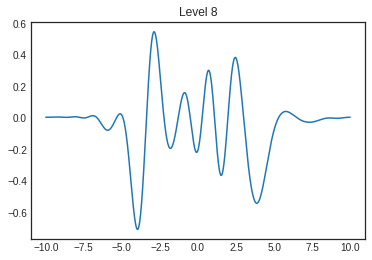

Square integrated over the region: 1.0000000000000213


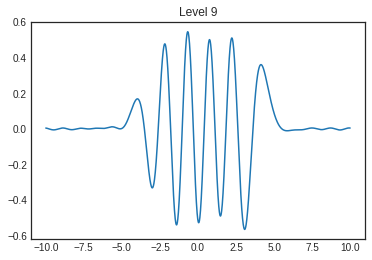

Square integrated over the region: 1.0000000000000215


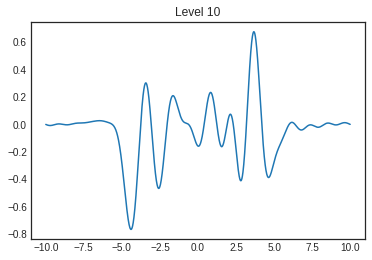

Square integrated over the region: 1.0000000000000213


In [21]:
x = np.arange(-10, 10 , 0.01)
k = n_FM
L = box_len
Y = FM(k, L, x)

SUP = np.matmul(Y, var_FC_N)

for i in range(n_EL+1):
    plt.plot(x, SUP[:, i])
    plt.title("Level " + str(i))
    plt.show()
    print("Square integrated over the region: " + str(np.sum(SUP[:, i] * SUP[:, i]) * 0.01)) #check wavefunction normalisation

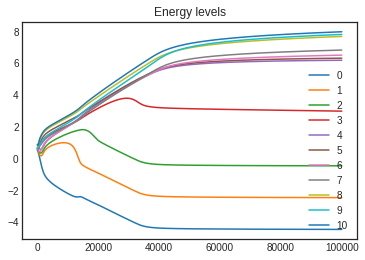

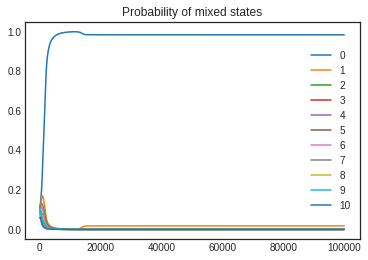

In [22]:
for i in range(n_EL+1):
    plt.plot(np.arange(epochs), levels_hist[:,i]*T, label = str(i))

plt.title("Energy levels")    
plt.legend()
plt.show()

for i in range(n_EL+1):
    plt.plot(np.arange(epochs), logits_hist[:,i], label = str(i))

plt.title("Probability of mixed states")    
plt.legend()
plt.show()

In [23]:
print("Energy: ")
print(levels_fin)
print("Probabilities: ")
print(logits_fin)

Energy: 
[-8.92824876 -4.92825422 -0.92825332  5.95367507 12.3573077  12.61834193
 12.99978801 13.63744035 15.35050612 15.60368465 15.94225322]
Probabilities: 
[9.81689962e-01 1.79803770e-02 3.29321797e-04 3.37937941e-07
 5.59467208e-10 4.30932166e-10 2.94272028e-10 1.55532120e-10
 2.80443307e-11 2.17716348e-11 1.55186015e-11]


## Maximum Likelihood